In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from datetime import date

warnings.filterwarnings("ignore")

from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,f1_score,precision_score,recall_score,roc_auc_score,roc_curve
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

In [172]:
df = pd.read_csv(r'visadata.csv')
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [173]:
df.duplicated().sum()

np.int64(0)

In [174]:
df.drop('case_id',inplace=True,axis=1)

In [175]:
today = date.today()
current_year=today.year
current_year

2026

In [176]:
df['company_age']=current_year - df['yr_of_estab']

In [177]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,19
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,24
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,18
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,129
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,21


In [178]:
df.drop('yr_of_estab',inplace=True,axis=1)

In [179]:
num_cols = [feature for feature in df.columns if df[feature].dtype != 'O']
cat_cols = [feature for feature in df.columns if df[feature].dtype == 'O']


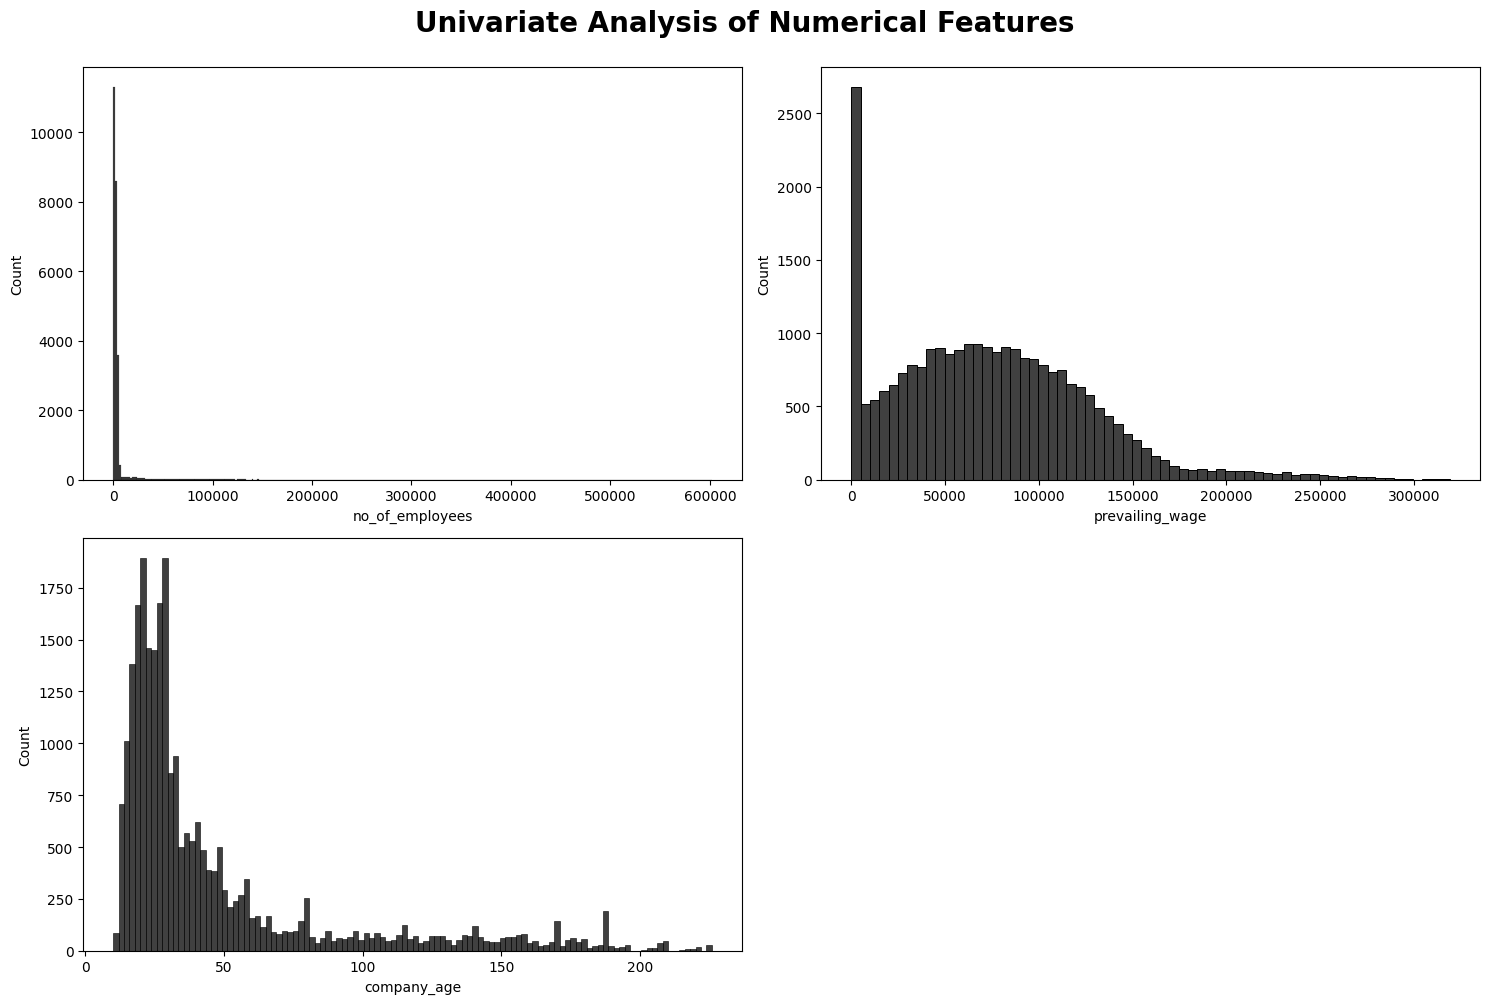

In [180]:
plt.figure(figsize=(15,10))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20,fontweight='bold',alpha=1,y=1.)

for i in range(0, len(num_cols)):
    plt.subplot(2,2, i+1)
    sns.histplot(x=df[num_cols[i]],color='black')
    plt.xlabel(num_cols[i])
    plt.tight_layout()

In [181]:
df[num_cols].skew()

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

##### As seen in the above visualization the columns 'no_of_employees' and 'company_age' are positively skewed. Therefore we will be using PowerTransformer class from scikit-learn module to overcome the skewness.

In [182]:
# Splitting the data into 'X' Feature matrix and 'y' Target Variable.

X = df.drop('case_status',axis=1)
y = df['case_status']

In [183]:
y = np.where(y=='Denied',1,0)

In [184]:
y

array([1, 0, 1, ..., 0, 0, 0], shape=(25480,))

In [185]:
# Using PowwerTransformer

pt = PowerTransformer(method='yeo-johnson')
transform_columns = ['no_of_employees','company_age']
X_copy = pt.fit_transform(X[transform_columns])

In [186]:
X_copy= pd.DataFrame(X_copy,columns=transform_columns)

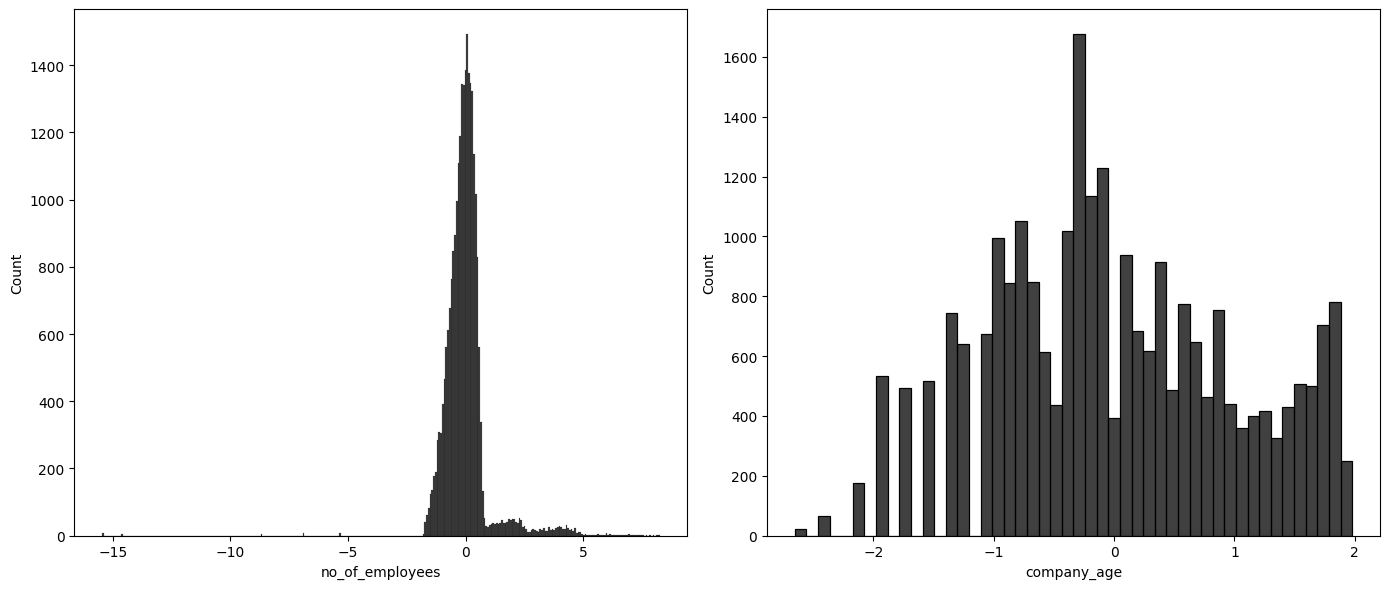

In [187]:
plt.figure(figsize=(14,6))
for i,cols in enumerate(transform_columns):
    plt.subplot(1,2, i+1)
    sns.histplot(x=X_copy[cols],color='black')
    plt.xlabel(cols)
    plt.tight_layout()

### Feature Engineering..

In [188]:
numeric_columns = X.select_dtypes(exclude='object').columns
numeric_columns

Index(['no_of_employees', 'prevailing_wage', 'company_age'], dtype='object')

In [189]:
X.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,19
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,24
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,18
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,129
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,21


In [190]:
X['education_of_employee'] = X['education_of_employee'].replace({
    "Bachelor's" : 'Bachelor',
    "Master's" : 'Master'
})

In [191]:
X['education_of_employee'].value_counts()

education_of_employee
Bachelor       10234
Master          9634
High School     3420
Doctorate       2192
Name: count, dtype: int64

In [192]:
#Separating columns to their respective Transformations.
or_columns = ['education_of_employee','has_job_experience','requires_job_training','full_time_position']
ohe_columns = ['continent','region_of_employment','unit_of_wage']
pt_columns = ['no_of_employees','company_age']

#Defining Order to the Education of employees column.
ed_order=['High School','Bachelor','Master','Doctorate']
binary_order = ['N', 'Y']
categories = [
    ed_order,
    binary_order,
    binary_order,
    binary_order
]

#Initializing Encoders.
or_encoder = OrdinalEncoder(categories=categories,handle_unknown="use_encoded_value",
    unknown_value=-1)
ohe = OneHotEncoder(drop='first', handle_unknown='ignore',
    sparse_output=False)
num_feat = StandardScaler()

transform_pipe = Pipeline(steps=[
    ('transform', PowerTransformer(method='yeo-johnson'))
])

#Initializing Column Transformer
preprocessor = ColumnTransformer(
    [
        ('onehot',ohe,ohe_columns),
        ('ordinal',or_encoder,or_columns),
        ('transformer',transform_pipe,pt_columns),
        ('scaler',num_feat,numeric_columns)
    ],remainder='passthrough'
)


In [193]:
X = preprocessor.fit_transform(X)

In [194]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [195]:
X_train.shape

(20384, 21)

In [196]:
def evaluate(true,predicted):
    acc = accuracy_score(true,predicted)
    precision = precision_score(true,predicted)
    recall = recall_score(true,predicted)
    f1 = f1_score(true,predicted)
    roc = roc_auc_score(true,predicted)
    return acc,precision,recall,f1,roc

In [197]:
models = {
    "RandomForest" : RandomForestClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "LogReg" : LogisticRegression(),
    "XgBoost" : XGBClassifier(),
    "CatBoot" : CatBoostClassifier(verbose=False),
    "AdaBoost" : AdaBoostClassifier(),
    "GradientBoost" : GradientBoostingClassifier(),
    "KNN" : KNeighborsClassifier(),
    "SVM" : SVC(class_weight='balanced'),

}

In [198]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train)

    #make Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #Training Set Performance
    model_train_acc, model_train_precision, model_train_recall, model_train_f1, model_train_roc = evaluate(y_train,y_train_pred)

    #Test Set Performance
    model_test_acc, model_test_precision, model_test_recall, model_test_f1, model_test_roc = evaluate(y_test,y_test_pred)


    print(list(models.keys())[i])


    print("Model Performance for Training Set")
    print("- Accuracy: {:.4f}".format(model_train_acc))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- F1: {:.4f}".format(model_train_f1))
    print("- ROC Score: {:.4f}".format(model_train_roc))

    print("-------------------------------")

    print("Model Performance for Test Set")
    print("- Accuracy: {:.4f}".format(model_test_acc))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- F1: {:.4f}".format(model_test_f1))
    print("- ROC Score: {:.4f}".format(model_test_roc))

    print("="*40)
    print("\n")

RandomForest
Model Performance for Training Set
- Accuracy: 0.9999
- Precision: 1.0000
- Recall: 0.9997
- F1: 0.9999
- ROC Score: 0.9999
-------------------------------
Model Performance for Test Set
- Accuracy: 0.7318
- Precision: 0.6260
- Recall: 0.4808
- F1: 0.5439
- ROC Score: 0.6688


DecisionTree
Model Performance for Training Set
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1: 1.0000
- ROC Score: 1.0000
-------------------------------
Model Performance for Test Set
- Accuracy: 0.6678
- Precision: 0.5006
- Recall: 0.5121
- F1: 0.5063
- ROC Score: 0.6287


LogReg
Model Performance for Training Set
- Accuracy: 0.7326
- Precision: 0.6464
- Recall: 0.4293
- F1: 0.5159
- ROC Score: 0.6563
-------------------------------
Model Performance for Test Set
- Accuracy: 0.7402
- Precision: 0.6716
- Recall: 0.4283
- F1: 0.5231
- ROC Score: 0.6620


XgBoost
Model Performance for Training Set
- Accuracy: 0.8309
- Precision: 0.8135
- Recall: 0.6368
- F1: 0.7144
- ROC Score: 0.7821
-

In [199]:
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [200]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [201]:
model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X, y)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
---------------- Best Params for XGBoost -------------------
{'min_child_weight': 1, 'max_depth': 3}
---------------- Best Params for RF -------------------
{'n_estimators': 50, 'max_features': None, 'max_depth': 10}
---------------- Best Params for KNN -------------------
{'weights': 'uniform', 'n_neighbors': 9, 'algorithm': 'auto'}


In [202]:
model_param

{'XGBoost': {'min_child_weight': 1, 'max_depth': 3},
 'RF': {'n_estimators': 50, 'max_features': None, 'max_depth': 10},
 'KNN': {'weights': 'uniform', 'n_neighbors': 9, 'algorithm': 'auto'}}

In [203]:
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
}

for i in range(len(list(best_models))):
    model = list(best_models.values())[i]
    model.fit(X_train,y_train)

    #make Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #Training Set Performance
    model_train_acc, model_train_precision, model_train_recall, model_train_f1, model_train_roc = evaluate(y_train,y_train_pred)

    #Test Set Performance
    model_test_acc, model_test_precision, model_test_recall, model_test_f1, model_test_roc = evaluate(y_test,y_test_pred)


    print(list(best_models.keys())[i])


    print("Model Performance for Training Set")
    print("- Accuracy: {:.4f}".format(model_train_acc))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- F1: {:.4f}".format(model_train_f1))
    print("- ROC Score: {:.4f}".format(model_train_roc))

    print("-------------------------------")

    print("Model Performance for Test Set")
    print("- Accuracy: {:.4f}".format(model_test_acc))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- F1: {:.4f}".format(model_test_f1))
    print("- ROC Score: {:.4f}".format(model_test_roc))

    print("="*40)
    print("\n")

Random Forest Classifier
Model Performance for Training Set
- Accuracy: 0.7824
- Precision: 0.7267
- Recall: 0.5524
- F1: 0.6277
- ROC Score: 0.7246
-------------------------------
Model Performance for Test Set
- Accuracy: 0.7529
- Precision: 0.6741
- Recall: 0.4979
- F1: 0.5728
- ROC Score: 0.6890


KNeighborsClassifier
Model Performance for Training Set
- Accuracy: 0.7706
- Precision: 0.7041
- Recall: 0.5327
- F1: 0.6065
- ROC Score: 0.7107
-------------------------------
Model Performance for Test Set
- Accuracy: 0.7202
- Precision: 0.6077
- Recall: 0.4478
- F1: 0.5156
- ROC Score: 0.6519


XGBClassifier
Model Performance for Training Set
- Accuracy: 0.7606
- Precision: 0.6825
- Recall: 0.5216
- F1: 0.5913
- ROC Score: 0.7005
-------------------------------
Model Performance for Test Set
- Accuracy: 0.7541
- Precision: 0.6735
- Recall: 0.5062
- F1: 0.5780
- ROC Score: 0.6919




In [207]:
best_model = XGBClassifier(**model_param['XGBoost'],n_jobs=-1)
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.7541
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      3401
           1       0.67      0.51      0.58      1695

    accuracy                           0.75      5096
   macro avg       0.73      0.69      0.70      5096
weighted avg       0.75      0.75      0.74      5096



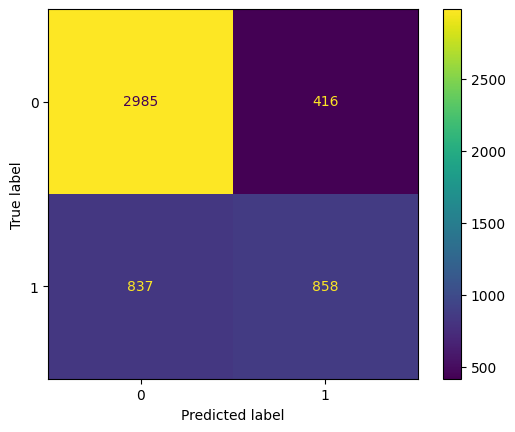

In [208]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)